# Classification Problem
Next I will develop a Logistic Regression model to predict different classes. More specifically Logistic Regression is used to estimate the probability that an instance, element or observation belongs to a certain class. The use of one of the most popular collections of information for the purpose of classification is the Titanic dataset and the model I have developed will be submitted to Kaggle's 'Titanic - Machine Learning from Disaster' competition.

The purpose of this model is to identify if these passengers 'Survived' or 'Not' which will involve creating a target output column populated with simple binary results of '1' or '0'.

1. Explore and clean the data
2. Split data into train / validation / test
3. Fit an initial model and evaluate
4. Tune hyper parameters
5. Evaluate on validation set
6. Final model selection and evaluation on test set

## Import the Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


## Ingest the Data

In [2]:
titanic = pd.read_csv('C:/Users/lynst/Documents/GitHub/machine-learning-projects/supervised-learning/regression/logistic-regression/titanic_data.csv')
titanic.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
1,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
2,6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
3,10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
4,11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [3]:
# check the column names and data types
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   183 non-null    int64  
 1   PassengerId  183 non-null    int64  
 2   Survived     183 non-null    int64  
 3   Pclass       183 non-null    int64  
 4   Name         183 non-null    object 
 5   Sex          183 non-null    object 
 6   Age          183 non-null    float64
 7   SibSp        183 non-null    int64  
 8   Parch        183 non-null    int64  
 9   Ticket       183 non-null    object 
 10  Fare         183 non-null    float64
 11  Cabin        183 non-null    object 
 12  Embarked     183 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 18.7+ KB


So I can determine there are a total of 183 entries in this dataset. Initial thoughts are that it might be worth using a more comprehensive dataset, one which might contain the full list of passengers (1309) rather than just a subset (183). This is the most comprehensive list available for the purpose of this exercise that I can find, although estimates for the total number of passengers and crew members are thought to be in the region of 2220. The most comprehensive datasets might be Encyclopedia Titanica and Wikipedia, both of which can be found online.

In [4]:
# importing once again
titanic = pd.read_csv('C:/Users/lynst/Documents/GitHub/machine-learning-projects/supervised-learning/regression/logistic-regression/titanic.csv',
                     header=0,
                     names = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin',
                              'Embarked','WikiId','Name_wiki','Age_wiki','Hometown','Boarded','Destination','Lifeboat','Body',
                              'Class'])
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,WikiId,Name_wiki,Age_wiki,Hometown,Boarded,Destination,Lifeboat,Body,Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,691.0,"Braund, Mr. Owen Harris",22.0,"Bridgerule, Devon, England",Southampton,"Qu'Appelle Valley, Saskatchewan, Canada",NaN,NaN,3.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,90.0,"Cumings, Mrs. Florence Briggs (née Thayer)",35.0,"New York, New York, US",Cherbourg,"New York, New York, US",4,NaN,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,865.0,"Heikkinen, Miss Laina",26.0,"Jyväskylä, Finland",Southampton,New York City,14?,NaN,3.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,127.0,"Futrelle, Mrs. Lily May (née Peel)",35.0,"Scituate, Massachusetts, US",Southampton,"Scituate, Massachusetts, US",D,NaN,1.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,627.0,"Allen, Mr. William Henry",35.0,"Birmingham, West Midlands, England",Southampton,New York City,NaN,NaN,3.0


## Feature Selection
Removing unwanted columns and rows and feature engineering is the next important step. Straight away I can see the second dataset I have imported from Kaggle which I have named 'titanic.csv' has a more comprehensive number of entries but also contains 21 columns as opposed to just 12 in the first set. Time to establish which of these columns will be kept or removed using some dimensionality reduction and combination, before establishing what is to be included in a Pandas DataFrame table and target Series.

In [5]:
# check the column names and data types
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  WikiId       1304 non-null   float64
 13  Name_wiki    1304 non-null   object 
 14  Age_wiki     1302 non-null   float64
 15  Hometown     1304 non-null   object 
 16  Boarded      1304 non-null   object 
 17  Destination  1304 non-null   object 
 18  Lifeboat     502 non-null    object 
 19  Body  

I can remove 'PassengerId', 'Name', 'Age', 'Ticket', 'Embarked', 'WikiId', 'Name_wiki', 'Hometown', 'Destination', 'Lifeboat', 'Body', 'Fare' and 'Class' which will significantly reduce clutter in my table as these features provide no causal relationship with passenger Survival, some of which also represent duplicated information such as passenger class 'Pclass' and 'Class'. This initial step of reducing the size helps provide a much more useful dataset overall.
Next, let's determine the index and column values.

In [6]:
titanic.shape

(1309, 21)

This tells me there are 1309 rows and 21 columns. Also, another way to find the number of entries or range of the index would be:

In [7]:
titanic.index

RangeIndex(start=0, stop=1309, step=1)

So the index starts at 0 and ends at 1308, a total of 1309 passengers (not including crew members), but in terms of the data entries in this table only 891 are labeled with target predictions. The model will be applied to the labeled data first, followed by the unlabeled data (418 entries).

### Some Descriptive Stats
Several of these values can come in handy in case I need to impute any averages for missing values later. Bear in mind this only contains data for columns with numeric values!

In [8]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,WikiId,Age_wiki,Class
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1304.000000,1302.000000,1304.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,658.534509,29.415829,2.291411
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,380.377373,13.758954,0.840852
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.170000,1.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,326.750000,21.000000,1.750000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,661.500000,28.000000,3.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,987.250000,37.750000,3.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1314.000000,74.000000,3.000000


In [9]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'WikiId', 'Name_wiki',
       'Age_wiki', 'Hometown', 'Boarded', 'Destination', 'Lifeboat', 'Body',
       'Class'],
      dtype='object')

### Dropping Columns
Store a copy of these columns in a new variable or dataset so I don't overwrite the information.

In [10]:
titanic_new = titanic[['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked',
                       'WikiId','Name_wiki','Age_wiki','Hometown','Boarded','Destination','Lifeboat','Body','Class']]
titanic_new.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,WikiId,Name_wiki,Age_wiki,Hometown,Boarded,Destination,Lifeboat,Body,Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,691.0,"Braund, Mr. Owen Harris",22.0,"Bridgerule, Devon, England",Southampton,"Qu'Appelle Valley, Saskatchewan, Canada",NaN,NaN,3.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,90.0,"Cumings, Mrs. Florence Briggs (née Thayer)",35.0,"New York, New York, US",Cherbourg,"New York, New York, US",4,NaN,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,865.0,"Heikkinen, Miss Laina",26.0,"Jyväskylä, Finland",Southampton,New York City,14?,NaN,3.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,127.0,"Futrelle, Mrs. Lily May (née Peel)",35.0,"Scituate, Massachusetts, US",Southampton,"Scituate, Massachusetts, US",D,NaN,1.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,627.0,"Allen, Mr. William Henry",35.0,"Birmingham, West Midlands, England",Southampton,New York City,NaN,NaN,3.0


The easiest way to drop the columns not required is to create a new subset of data (2d array) with the specified columns to be used.

In [11]:
titanic_reduced = titanic_new[['Survived','Pclass','Sex','SibSp','Parch','Cabin','Age_wiki','Boarded','Fare']]
titanic_reduced.head()

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Age_wiki,Boarded,Fare
0,0.0,3,male,1,0,NaN,22.0,Southampton,7.2500
1,1.0,1,female,1,0,C85,35.0,Cherbourg,71.2833
2,1.0,3,female,0,0,NaN,26.0,Southampton,7.9250
3,1.0,1,female,1,0,C123,35.0,Southampton,53.1000
4,0.0,3,male,0,0,NaN,35.0,Southampton,8.0500


I am using 'Age_wiki' from the Wikipedia web site which appears to be a much more comprehensive set of data than that of the 'Age' column. The 'Boarded' column has nominal data which I will endeavour to convert to numeric values so each port a passenger embarks from will be represented by a number instead. This will help provide more uniform data types. 'Sex' can also be converted to 0's or 1's for the purpose of this exercise and the 'SibSp' and 'Parch' columns can be combined using feature extraction to concatenate the size of families into a new series. The 'Cabin' data will be converted to binary integer values for simplicity and the 'Pclass' (Passenger Class) observations are already denoted as integer values. These appear to have a significant impact on passenger survival so I'm including them.

Reducing the number of features is called dimensionality reduction and is an important technique used to achieve comparable results in a much faster time frame (with little benefit to performance accuracy), but generally works better with much larger datasets. The removal of all the unwanted columns contained in the modified dataset variable helps speed the model up.

In [12]:
# Partial or subset of titanic dataframe
df = pd.DataFrame({
    'Survived': pd.Series(titanic_reduced['Survived']),
    'Pclass': pd.Series(titanic_reduced['Pclass']),
    'Sex': pd.Series(titanic_reduced['Sex']),
    'SibSp': pd.Series(titanic_reduced['SibSp']),
    'Parch': pd.Series(titanic_reduced['Parch']),
    'Cabin': pd.Series(titanic_reduced['Cabin']),
    'Age_wiki': pd.Series(titanic_reduced['Age_wiki']),
    'Boarded': pd.Series(titanic_reduced['Boarded']),
    'Fare': pd.Series(titanic_reduced['Fare'])
})

df

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Age_wiki,Boarded,Fare
0,0.0,3,male,1,0,NaN,22.0,Southampton,7.2500
1,1.0,1,female,1,0,C85,35.0,Cherbourg,71.2833
2,1.0,3,female,0,0,NaN,26.0,Southampton,7.9250
3,1.0,1,female,1,0,C123,35.0,Southampton,53.1000
4,0.0,3,male,0,0,NaN,35.0,Southampton,8.0500
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,0,0,NaN,23.0,Southampton,8.0500
1305,NaN,1,female,0,0,C105,39.0,Cherbourg,108.9000
1306,NaN,3,male,0,0,NaN,43.0,Southampton,7.2500
1307,NaN,3,male,0,0,NaN,34.0,Southampton,8.0500


Which columns or features are left now?

In [13]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Age_wiki',
       'Boarded', 'Fare'],
      dtype='object')

## Clean the Data
### Missing Values
Next it's really important to remove or impute any Null or missing values. This depends on any row values which are missing and also on the data type for each column. Calculating the total number of missing or Null values across the entire 'titanic' dataset gives:

In [14]:
titanic_missing = pd.isnull(titanic).sum()
print(titanic_missing)

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
WikiId            5
Name_wiki         5
Age_wiki          7
Hometown          5
Boarded           5
Destination       5
Lifeboat        807
Body           1179
Class             5
dtype: int64


More specifically, to narrow my workable dataset down and find the total number of missing values from the entire dataset:

In [15]:
df_missing = pd.isnull(df).sum()
print(df_missing)

Survived     418
Pclass         0
Sex            0
SibSp          0
Parch          0
Cabin       1014
Age_wiki       7
Boarded        5
Fare           1
dtype: int64


Next it becomes useful to determine if these missing values occurred because they weren't recorded or because there was no information for them? Assessing this output I can determine that the null values in 'Cabin' simply represent those who did not have a cabin for sleeping quarters and so these would not have been recorded. These passengers would have traveled in other areas of the ship so it's important not to drop these values as they represent important data and account for over three quarters of the overall number of passengers in this particular set. 

There are also 5 null values for the 'Boarded' column so for whatever reason these passengers did not have their boarding locations recorded. It's impossible to really know which port location these individuals departed from so I can either leave the values as NaN or remove each of these 5 entries as a value should exist if they boarded legally and other attributes were recorded, e.g. Name, Class, Cabin or even Age.

### Null Values for Age
The 'Age-wiki' feature records the ages provided by passengers when purchasing their tickets so it was likely based on the D.O.B. in their travel documents or passports. Taking a look at the total number of Null or missing values for the 'Age_wiki' column first:

In [16]:
num_age_null = df['Age_wiki'].isnull().sum()
print(num_age_null)

7


Identifying each row in the dataframe which contains a null value for 'Age_wiki'.

In [17]:
df[df['Age_wiki'].isnull()]

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Age_wiki,Boarded,Fare
42,0.0,3,male,0,0,NaN,NaN,Cherbourg,7.8958
347,1.0,3,female,1,0,NaN,NaN,NaN,16.1000
420,0.0,3,male,0,0,NaN,NaN,Cherbourg,7.8958
557,0.0,1,male,0,0,NaN,NaN,NaN,227.5250
1041,NaN,1,female,0,1,C54,NaN,NaN,83.1583
1048,NaN,3,female,0,0,NaN,NaN,NaN,7.8542
1228,NaN,3,male,0,2,NaN,NaN,NaN,7.2292


I can make a decision whether to include these 7 passengers and merely impute some average age for their respective 'Sex', impute an average based on the overall mean for both genders, or remove them completely. Seeing as the majority of information for each of these passengers (roughly 4/7ths to 5/7ths) is present I would prefer to keep these entries, so imputing mean values for age based on the individuals sex may be a reasonably accurate average.

The mean age for everyone, regardless of sex is 29.88 according to the describe() method above. Another way to find the overall average age is:

In [18]:
df.groupby(df['Age_wiki'].isnull()).mean()

,Survived,Pclass,SibSp,Parch,Age_wiki,Fare
Age_wiki,,,,,,
False,0.384442,2.294163,0.500768,0.384793,29.415829,33.199715
True,0.250000,2.428571,0.142857,0.428571,NaN,51.094043


This overall mean or average may not be as accurate as calculating the average age for both male and female passengers and imputing them into the 7 missing values.

### Calculate Average Age
Calculating the average age for male and female passengers in the table can be done by summing each individual age (by sex) and dividing by the total number of male or female passengers respectively.

In [19]:
# find the total count of each of the two unique values in the Sex column (total male or female passengers)
df['Sex'].value_counts().unique()

array([843, 466], dtype=int64)

This is based on all 1309 passengers.

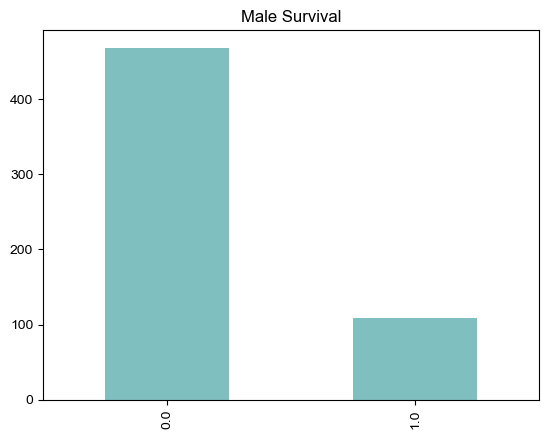

In [20]:
import seaborn as sns

df.Survived[df.Sex == 'male'].value_counts().plot(kind='bar', alpha=0.5, color='teal')
plt.title("Male Survival")
# create style
sns.set_style("ticks")

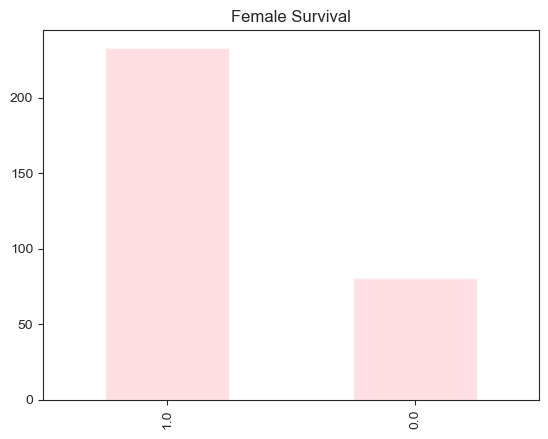

In [21]:
df.Survived[df.Sex == 'female'].value_counts().plot(kind='bar', alpha=0.5, color='pink')
plt.title("Female Survival")
# create style
sns.set_style("ticks")

So having determined the unique classes within the 'Sex' column I can further identify the number of Males and Females who survived or not. By taking the 'Survived' column and sub-dividing it according to gender it displays how women were far more likely to have survived the Titanic disaster based on the predictor variables included with this dataset.

Next I want to group each category of male and female and store them in a variable called 'gender'.

In [22]:
gender = df.groupby(df['Sex'])
gender.head()

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Age_wiki,Boarded,Fare
0,0.0,3,male,1,0,NaN,22.0,Southampton,7.2500
1,1.0,1,female,1,0,C85,35.0,Cherbourg,71.2833
2,1.0,3,female,0,0,NaN,26.0,Southampton,7.9250
3,1.0,1,female,1,0,C123,35.0,Southampton,53.1000
4,0.0,3,male,0,0,NaN,35.0,Southampton,8.0500
5,0.0,3,male,0,0,NaN,22.0,Queenstown,8.4583
6,0.0,1,male,0,0,E46,54.0,Southampton,51.8625
7,0.0,3,male,3,1,NaN,2.0,Southampton,21.0750
8,1.0,3,female,0,2,NaN,26.0,Southampton,11.1333
9,1.0,2,female,1,0,NaN,14.0,Cherbourg,30.0708


Checking the first few entries for both sexes:

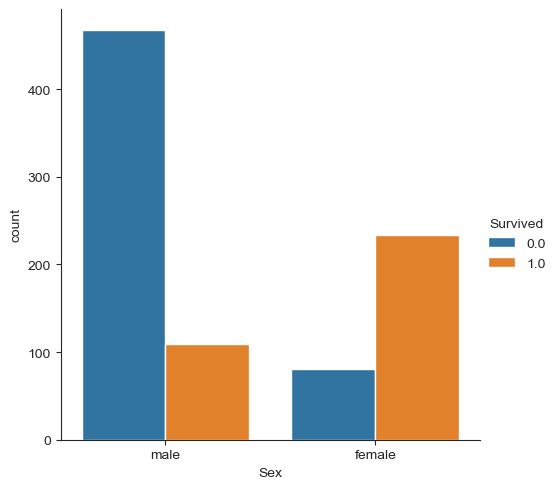

In [23]:
# Import Library
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot
sns.catplot(x ="Sex", hue ="Survived",
kind ="count", data = df)

Now there are two variables, one with all the male and one with all the female passengers in the Titanic dataset. There are a total of 843 male and 466 female passengers.

The next step is to add these totals together.

In [24]:
male_total = 843
female_total = 466
total_passengers = male_total + female_total
total_passengers

1309

Summing the total of all ages for all the passengers:

In [25]:
sum_age = df['Age_wiki'].sum()
print(sum_age)

38299.41


And dividing by the total number of passengers:

In [26]:
age_ave = sum_age / total_passengers
age_ave

29.25852559205501

So the overall average age for all passengers calculates to just over 29 years old. Using the describe method to check this gives:

In [27]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,WikiId,Age_wiki,Class
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1304.000000,1302.000000,1304.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,658.534509,29.415829,2.291411
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,380.377373,13.758954,0.840852
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.170000,1.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,326.750000,21.000000,1.750000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,661.500000,28.000000,3.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,987.250000,37.750000,3.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1314.000000,74.000000,3.000000


So the first item to notice is that only numeric data appears to have been captured which will need to be fixed soon, but the answer I was looking for now, the mean age found under the 'Age-wiki' column is 29.415829 which is close to the value just calculated of 29.258525, but not identical.

Next, to see the average ages for both male and female classes:

In [28]:
df.groupby(by='Sex')['Age_wiki'].mean()

Sex
female    28.418467
male      29.966222
Name: Age_wiki, dtype: float64

So this produces the mean Age by Sex. 

What if I wanted to find an average age just for the missing values? There are a total of 7 missing age values in the entire dataset, 4 male and 3 female. Imputing a value of 29 for the missing 'male' age and 28 for 'female' would be the most accurate solution but instead, the mean age value for all passengers will be imputed.

In [29]:
df.isnull().sum()

Survived     418
Pclass         0
Sex            0
SibSp          0
Parch          0
Cabin       1014
Age_wiki       7
Boarded        5
Fare           1
dtype: int64

### Imputing Missing Age Values
Using the 'impute' library rather than using fillna().

In [30]:
from sklearn.impute import SimpleImputer

# Use SimpleImputer function to fill in missing values
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
age_imputer = imputer.fit(df[['Age_wiki']])
# now the transform method
df['Age_wiki'] = age_imputer.transform(df[['Age_wiki']])
df['Age_wiki'].head()

0    22.0
1    35.0
2    26.0
3    35.0
4    35.0
Name: Age_wiki, dtype: float64

All 'Age_wiki' observations are entered as floats but the data type needs to be changed to integer (representing years) which is technically more correct as a unit of measurement.

In [31]:
df['Age_wiki'] = df['Age_wiki'].astype('int')
df['Age_wiki'].head()

0    22
1    35
2    26
3    35
4    35
Name: Age_wiki, dtype: int32

So checking the first missing age value to see what value it contains now:

In [32]:
df.Age_wiki[42:43]

42    29
Name: Age_wiki, dtype: int32

The average age of 29 has been imputed. Another of the missing values was located at index 1041:

In [33]:
df.Age_wiki[1041:1042]

1041    29
Name: Age_wiki, dtype: int32

This also appears to be correct. 

To check if there are any more null values now they have been replaced with the mean age.

In [34]:
# check if Age_wiki has any more null values
df['Age_wiki'].isnull().sum()

0

This tells me all the null values in the Age column have been replaced properly. 

Now the missing values have been dealt with, what about the string and categorical variables in the dataset? An important consideration to make when using visualizations would be the data types involved. For example, information can be split into numeric (quantitative) data and categorical (qualitative) data. Categorical data values could be classified as Binary (such as the target outcome 'Survived', or 'Sex'), Nominal (such as 'Cabin', or 'Boarded'), perhaps even Ordinal (such as 'Pclass'). 'Age_wiki' contains continuous values and the rest such as 'SibSp' (number of Siblings or Spouse) and 'Parch' (number of Children accompanied by Parents) are discrete integer values.

Having established the different different data types the next step is to convert the string objects into numeric types, starting with the data in 'Cabin' first.

### Null Values for Cabin
Checking the total number of Null values for the 'Cabin' feature:

In [35]:
num_cabin_null = df['Cabin'].isnull().sum()
print(num_cabin_null)

1014


### Convert the Cabin Feature
Next, I want to address the issue relating to Cabin data. Because each passenger was assigned a Cabin number which is just an alpha-numeric string type, I would prefer to convert all entries for Cabin to a straight forward integer. Assigning a value of 1 for the presence of a cabin number and 0 for someone without.
#### Creating a Binary Indicator for Cabin

In [36]:
# Overwrite the Cabin values having converted them and store them in the same name
df['Cabin'] = np.where(df['Cabin'].isnull(), 0, 1)
df['Cabin'].head()

0    0
1    1
2    0
3    1
4    0
Name: Cabin, dtype: int32

Now the 'Cabin' data has been converted into binary numeric values equivalent to 'cabin' or 'no cabin' and even though there are 1014 passengers who were not assigned cabins, this data will remain.

In [37]:
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Age_wiki,Boarded,Fare
0,0.0,3,male,1,0,0,22,Southampton,7.2500
1,1.0,1,female,1,0,1,35,Cherbourg,71.2833
2,1.0,3,female,0,0,0,26,Southampton,7.9250
3,1.0,1,female,1,0,1,35,Southampton,53.1000
4,0.0,3,male,0,0,0,35,Southampton,8.0500


### Convert the Sex Feature
The male entries will be assigned a value of 1 and female, 0. Viewing the total number of Male passengers who didn't survive (0.0), or did survive (1.0), these can be switched to integer values also. This can be repeated for the Female passengers also.

In [38]:
gender_dict = {'male': 1, 'female': 0}
df['Sex'] = df['Sex'].map(gender_dict)

Check the dataframe again!

In [39]:
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Age_wiki,Boarded,Fare
0,0.0,3,1,1,0,0,22,Southampton,7.2500
1,1.0,1,0,1,0,1,35,Cherbourg,71.2833
2,1.0,3,0,0,0,0,26,Southampton,7.9250
3,1.0,1,0,1,0,1,35,Southampton,53.1000
4,0.0,3,1,0,0,0,35,Southampton,8.0500


### Null Values for Fare
There is only one missing value. I could replace the missing fare with the overall mean or median value, but I have opted to adjust the strategy argument in the SimpleImputer() method with the 'most_frequent' value.

In [40]:
from sklearn.impute import SimpleImputer

# Use SimpleImputer model to fill in missing entries with most frequent value
imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
fare_imputer = imputer.fit(df[['Fare']])
df['Fare'] = fare_imputer.transform(df[['Fare']])

#imputer = fare_imputer.fit_transform(fare_imputer.values.reshape(-1,1))
df[['Fare']].head()

,Fare
0,7.2500
1,71.2833
2,7.9250
3,53.1000
4,8.0500


In [41]:
df.Fare.fillna(df.Fare.mean(), inplace=True)

### Null Values for Boarded
The last categorical feature which needs changing is the 'Boarded' column. Checking if there are null values in 'Boarded':

In [42]:
df['Boarded'].isnull().sum()

5

Which 5 indexed rows are missing in the 'Boarded' column?

In [43]:
# list index values in relation to this column which are missing
boarded_values_null = df[df['Boarded'].isnull()]
boarded_values_null

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Age_wiki,Boarded,Fare
347,1.0,3,0,1,0,0,29,NaN,16.1000
557,0.0,1,1,0,0,0,29,NaN,227.5250
1041,NaN,1,0,0,1,1,29,NaN,83.1583
1048,NaN,3,0,0,0,0,29,NaN,7.8542
1228,NaN,3,1,0,2,0,29,NaN,7.2292


Because there are only five missing entries, it makes more sense to drop these rows from the database completely as it would be difficult to calculate or impute values for the departure port.

This means when it comes to preparing the dataframe to be used for our predictors, the row index numbers for these entries should be removed completely, thus deleting the information across all the columns.

In [44]:
df.drop([347, 557, 1041, 1048, 1228], axis=0, inplace=True)
df

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Age_wiki,Boarded,Fare
0,0.0,3,1,1,0,0,22,Southampton,7.2500
1,1.0,1,0,1,0,1,35,Cherbourg,71.2833
2,1.0,3,0,0,0,0,26,Southampton,7.9250
3,1.0,1,0,1,0,1,35,Southampton,53.1000
4,0.0,3,1,0,0,0,35,Southampton,8.0500
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,0,0,0,23,Southampton,8.0500
1305,NaN,1,0,0,0,1,39,Cherbourg,108.9000
1306,NaN,3,1,0,0,0,43,Southampton,7.2500
1307,NaN,3,1,0,0,0,34,Southampton,8.0500


So the dataframe has now been reduced from 1309 to 1304 entries.

In [45]:
# check if Boarded has any more missing values
df['Boarded'].isnull().sum()

0

An alternative approach would be to replace the missing values with the most frequently occurring entries using the fillna() method. Having observed these five entries in the source dataset there doesn't appear to be much information in the other columns so they probably wouldn't add much value to our model.

To identify which columns are categorical features:

In [46]:
# Get list of categorical variables from df
cat_vars = (df.dtypes == 'object')
object_cols = list(cat_vars[cat_vars].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Boarded']


### Convert the Boarded Feature
Because 'Boarded' values are just 'nominal', it doesn't make sense to use 'ordinal' encoding to categorize each departure location as there is no precedent regarding importance. A more appropriate way to convert the categorical entries for the Boarded column is to change its entries into numeric values using 'One-Hot Encoding'.

#### Creating a One-Hot Encoding Matrix for Boarded
There are four possible states for the 'Boarded' column including Belfast, Queenstown, Southampton and Cherbourg which were the only departure locations listed. Each of these entries can be assigned a value of 1,2 or 3. This can be achieved using a technique called one-hot encoding.

Check the values in the specific series I want.

In [47]:
boarded_cat = df[['Boarded']]
boarded_cat.head()

,Boarded
0,Southampton
1,Cherbourg
2,Southampton
3,Southampton
4,Southampton


Apply the 'One-Hot Encoder' class from the sci-kit learn library.

In [48]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(categories='auto', drop=None, sparse=True, dtype='int64', handle_unknown='error')
boarded_cat_1hot = one_hot_encoder.fit_transform(boarded_cat)
boarded_cat_1hot.toarray()

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0]], dtype=int64)

Check to see if the Boarded column has changed to numeric values.

In [49]:
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Cabin,Age_wiki,Boarded,Fare
0,0.0,3,1,1,0,0,22,Southampton,7.2500
1,1.0,1,0,1,0,1,35,Cherbourg,71.2833
2,1.0,3,0,0,0,0,26,Southampton,7.9250
3,1.0,1,0,1,0,1,35,Southampton,53.1000
4,0.0,3,1,0,0,0,35,Southampton,8.0500


So the Boarded column doesn't appear to have changed. 

#### Use the Column Transformer
This will extrapolate the existing data and extend the dtaa into new columns.

In [50]:
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(), ['Boarded', 'Sex']),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
updated_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
updated_df.head()

,onehotencoder__Boarded_Belfast,onehotencoder__Boarded_Cherbourg,onehotencoder__Boarded_Queenstown,onehotencoder__Boarded_Southampton,onehotencoder__Sex_0,onehotencoder__Sex_1,remainder__Survived,remainder__Pclass,remainder__SibSp,remainder__Parch,remainder__Cabin,remainder__Age_wiki,remainder__Fare
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,22.0,7.2500
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,35.0,71.2833
2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,26.0,7.9250
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,35.0,53.1000
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,35.0,8.0500


Tidying up the column names in the new dataframe. Make sure you initiate the 'self' class argument by typing in the name of the dataframe itself (updated_df), or else the rename() method won't work.

In [51]:
updated_df = pd.DataFrame.rename(updated_df, columns={'onehotencoder__Boarded_Belfast':'Boarded_Belfast',
                            'onehotencoder__Boarded_Cherbourg':'Boarded_Cherbourg',
                            'onehotencoder__Boarded_Queenstown':'Boarded_Queenstown',
                            'onehotencoder__Boarded_Southampton':'Boarded_Southampton',
                            'onehotencoder__Sex_0':'Female',
                            'onehotencoder__Sex_1':'Male',
                            'remainder__Survived':'Survived',
                            'remainder__Pclass':'Pclass',
                            'remainder__SibSp':'SibSp',
                            'remainder__Parch':'Parch',
                            'remainder__Cabin':'Cabin',
                            'remainder__Age_wiki':'Age_wiki',
                            'remainder__Fare':'Fare'})
updated_df.head()

,Boarded_Belfast,Boarded_Cherbourg,Boarded_Queenstown,Boarded_Southampton,Female,Male,Survived,Pclass,SibSp,Parch,Cabin,Age_wiki,Fare
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,22.0,7.2500
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,35.0,71.2833
2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,26.0,7.9250
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,35.0,53.1000
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,35.0,8.0500


Now all the data has been converted to numeric values into a more comprehensive set the performance of the model will be improved dramatically. One interesting visual summarizing the data dispersion of all the features would be a hist plot. This provides a frequency distribution of discrete and continuous variables. 

For example, we can qualify discrete variables as those which occupy a specific number of states determined by 1 / k where k equals the number of possible outcomes within this universal set. Determining the likelihood of each state occurring is calculated using a probability mass function. This would include 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch' and 'Cabin' below.

Continuous variables have an infinite number of possible values and act as real numbers. These values are calculated using a probability density function which does not provide the probability of a specific state, for example, 'Age_wiki' and 'Fare'.

array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>,
        <AxesSubplot:title={'center':'Sex'}>],
       [<AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Cabin'}>],
       [<AxesSubplot:title={'center':'Age_wiki'}>,
        <AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>]],
      dtype=object)

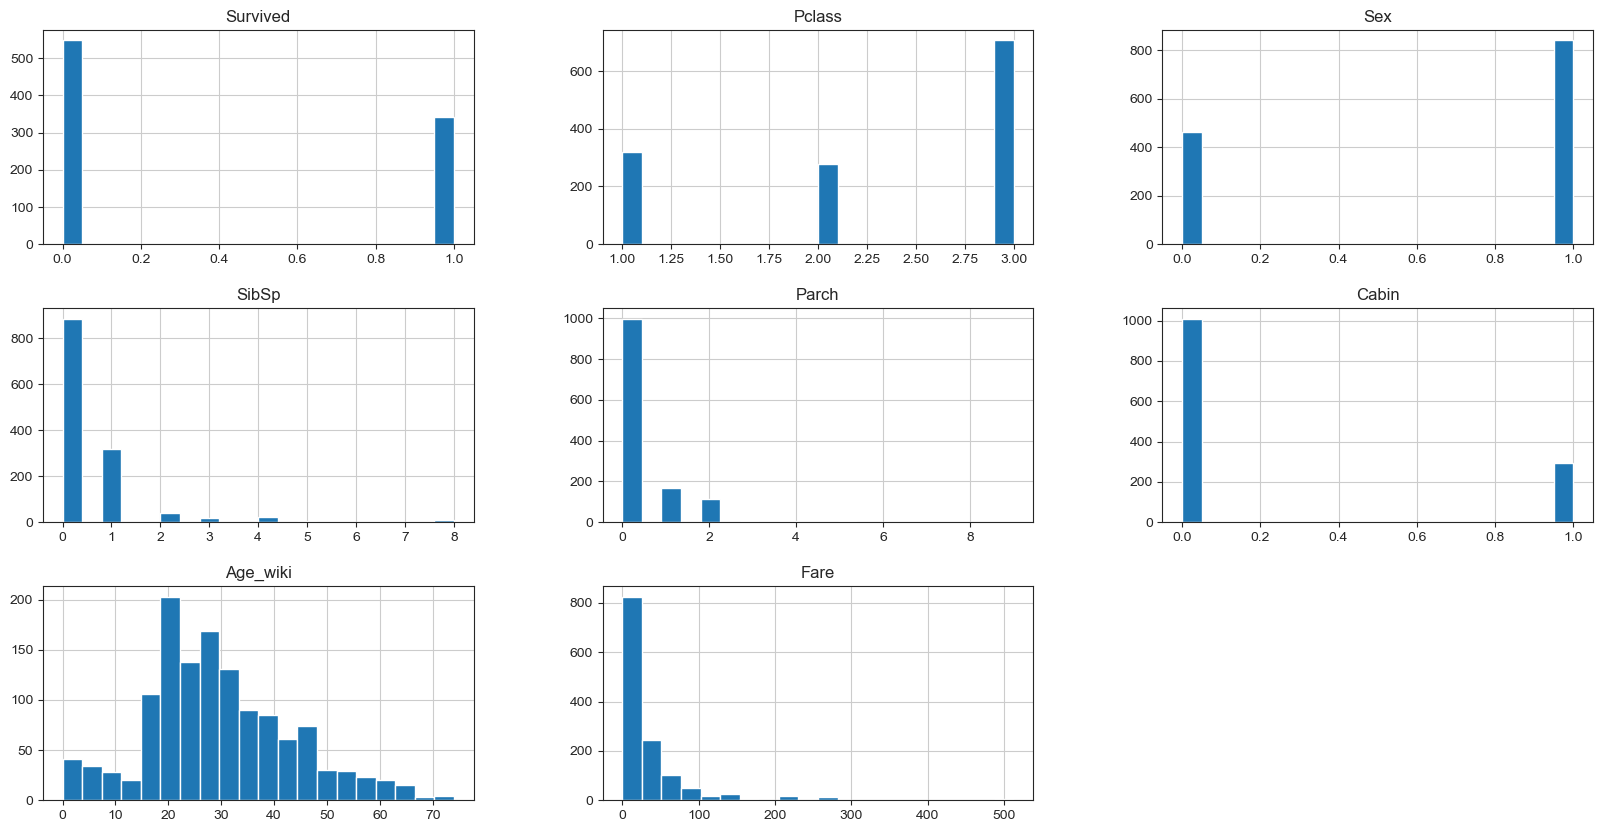

In [52]:
df.hist(bins=20, figsize=(20,10))          # Boarded is not included because it contains string data types

Taking a quick glance at the frequency distributions for each column reveals some interesting information. For example there are 2 distinct categories for survival, there don't appear to be any Sibling-Spouse groups larger than 8 in total, there's an average age of roughly 20-21 years, there are 3 distinct passenger classes (1st, 2nd and 3rd), an overwhelming number of People travelling without minors and much smaller numbers of Parents travelling with just 1 or 2 children. Finally, the vast majority of fares appear to be below the 25.0 mark, but there were some almost approaching 275.0. I'm not sure if these are Schillings, Guineas or Pounds Sterling, but this data can be further researched.

When it comes to visualizing these different types of data it is generally better to use scatter and line plots for numeric data, but for categorical data, frequency distributions, bar charts and histograms may be a better approach for viewing different classes or sub-sets of values.

The following Seaborn plots provide a breakdown of the relationship between the three categorical variables and the rate of survival in each. One thing to note is that the survival rate for passengers with a cabin approximates 0.4 (40%), so it would seem that 0.6 (60%) of those without a cabin had survived.

<Figure size 640x480 with 0 Axes>

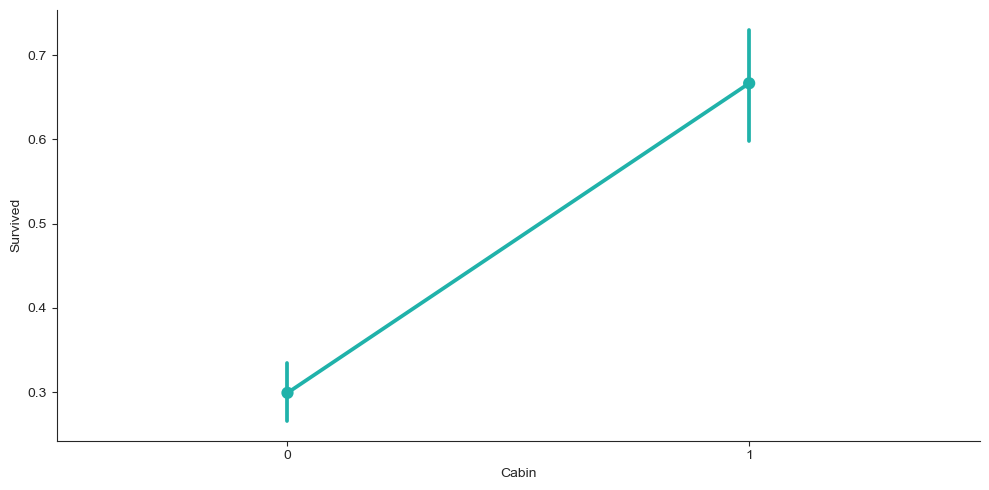

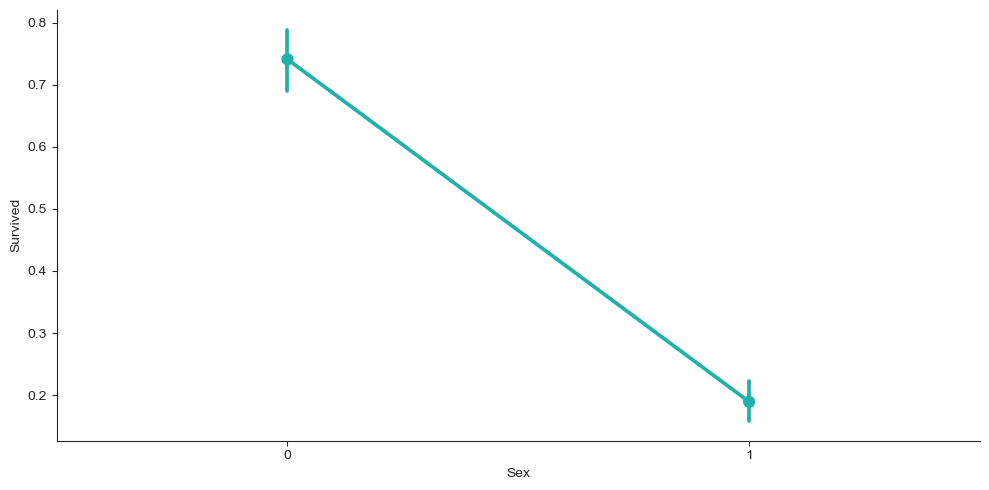

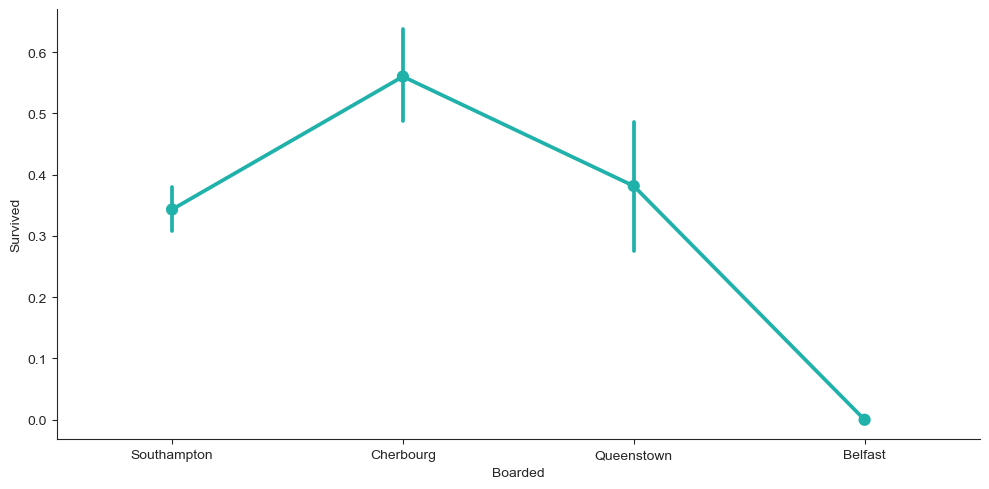

In [53]:
for i, col in enumerate(['Cabin', 'Sex', 'Boarded']):
    plt.figure(i)
    sns.catplot(x=col, y='Survived', data=df, kind='point', aspect=2, color="lightseagreen")

So I have the passenger survival rates from the different locations above and the percentage number of those passengers who embarked from each port, below.

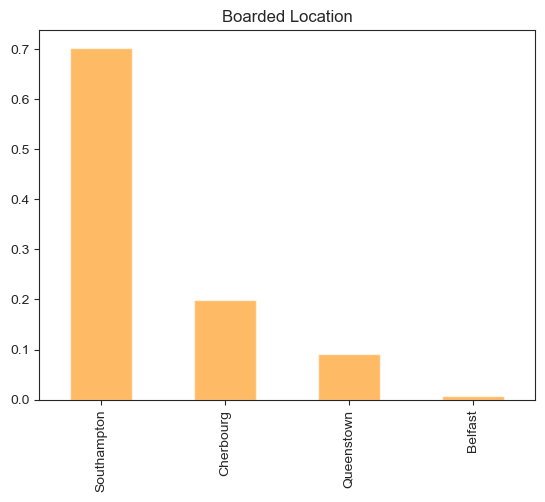

In [54]:
df.Boarded.value_counts(normalize=True).plot(kind="bar", alpha=0.6, color="darkorange")
plt.title("Boarded Location")
plt.show()

Total passengers by Boarding location:

In [55]:
df[0:891]['Boarded'].value_counts()

Southampton    640
Cherbourg      166
Queenstown      76
Belfast          9
Name: Boarded, dtype: int64

Group the different Boarding locations by the column I want information returned on which is 'Survived'.

In [56]:
df[0:891].groupby(['Boarded'], as_index=False)['Survived'].value_counts()

,Boarded,Survived,count
0,Belfast,0.0,9
1,Cherbourg,1.0,93
2,Cherbourg,0.0,73
3,Queenstown,0.0,47
4,Queenstown,1.0,29
5,Southampton,0.0,419
6,Southampton,1.0,219


To visualize this.

<AxesSubplot:title={'center':'Survival Rate by Boarding Location'}>

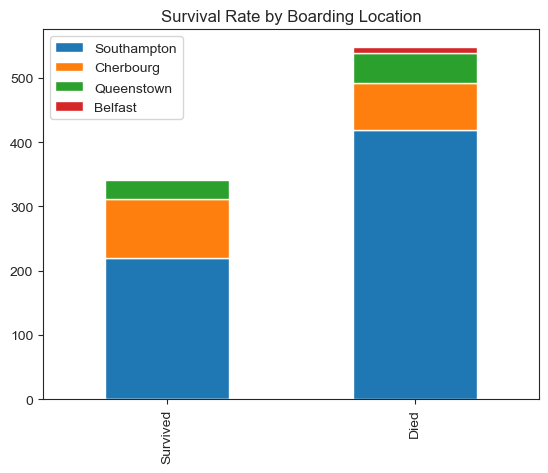

In [57]:
# Stacked barplot with pandas
Survived = df.loc[df['Survived']==1, :]['Boarded'].value_counts()
Died = df.loc[df['Survived']==0, :]['Boarded'].value_counts()
df_plot = pd.DataFrame([Survived,Died])
df_plot.index = ['Survived','Died']

# Plot
df_plot.plot(kind='bar',stacked=True, title='Survival Rate by Boarding Location')

This produces an interesting plot because straight away I am able to see that more people died from Southampton than the entire number of those who survived and nobody from Belfast survived at all.

If I flip the x-axis variables to contain the 'Boarded' locations I can compare the number of passengers who embarked from these locations to their actual survival rate in a stacked bar chart.

<AxesSubplot:title={'center':'Survival by Boarding Port Location'}>

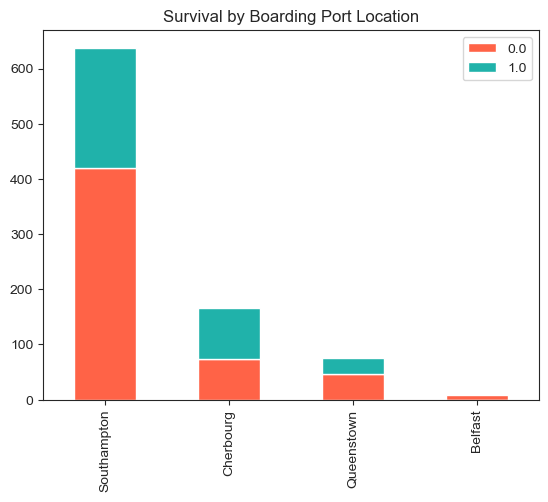

In [58]:
# Stacked barplot with pandas
Southampton = df.loc[df['Boarded']=='Southampton', :]['Survived'].value_counts()
Cherbourg = df.loc[df['Boarded']=='Cherbourg', :]['Survived'].value_counts()
Queenstown = df.loc[df['Boarded']=='Queenstown', :]['Survived'].value_counts()
Belfast = df.loc[df['Boarded']=='Belfast', :]['Survived'].value_counts()

df_plot = pd.DataFrame([Southampton,Cherbourg,Queenstown,Belfast])
df_plot.index=['Southampton','Cherbourg','Queenstown','Belfast']
df_plot.plot(kind='bar',stacked=True, color=['tomato','lightseagreen'], title='Survival by Boarding Port Location')

0.0 (tomato color) represents passengers who died and 1.0 (lightseagreen) those who survived in terms of the legend. It looks as if at least two-thirds to three-quarters of all passengers did not make it. At least 55% of overall passengers who survived had embarked from Cherbourg, at least 65% of passengers who were allocated a cabin survived and an overwhelming number of survivor's were Female.

Another important table I like is the correlation matrix which does a great job of describing the relative relationships between all the different variables.

In [59]:
correlation = updated_df.corr()
correlation

,Boarded_Belfast,Boarded_Cherbourg,Boarded_Queenstown,Boarded_Southampton,Female,Male,Survived,Pclass,SibSp,Parch,Cabin,Age_wiki,Fare
Boarded_Belfast,1.000000,-0.043765,-0.027858,-0.135072,-0.065227,0.065227,-0.079775,-0.073029,-0.042151,-0.039029,-0.005356,0.016553,-0.050841
Boarded_Cherbourg,-0.043765,1.000000,-0.157763,-0.764933,0.088527,-0.088527,0.174087,-0.256017,-0.035944,-0.018899,0.241974,0.061317,0.261751
Boarded_Queenstown,-0.027858,-0.157763,1.000000,-0.486907,0.087634,-0.087634,-0.001256,0.247764,-0.054904,-0.097612,-0.158228,-0.091549,-0.139562
Boarded_Southampton,-0.135072,-0.764933,-0.486907,1.000000,-0.120008,0.120008,-0.132189,0.081285,0.073994,0.085425,-0.110472,0.000999,-0.130808
Female,-0.065227,0.088527,0.087634,-0.120008,1.000000,-1.000000,0.542173,-0.125803,0.109880,0.215029,0.136569,-0.053710,0.189045
Male,0.065227,-0.088527,-0.087634,0.120008,-1.000000,1.000000,-0.542173,0.125803,-0.109880,-0.215029,-0.136569,0.053710,-0.189045
Survived,-0.079775,0.174087,-0.001256,-0.132189,0.542173,-0.542173,1.000000,-0.342075,-0.036412,0.082007,0.317708,-0.050067,0.263895
Pclass,-0.073029,-0.256017,0.247764,0.081285,-0.125803,0.125803,-0.342075,1.000000,0.060192,0.018088,-0.714405,-0.420597,-0.557114
SibSp,-0.042151,-0.035944,-0.054904,0.073994,0.109880,-0.109880,-0.036412,0.060192,1.000000,0.375192,-0.008799,-0.248555,0.162924
Parch,-0.039029,-0.018899,-0.097612,0.085425,0.215029,-0.215029,0.082007,0.018088,0.375192,1.000000,0.036145,-0.123296,0.224594


Presenting a correlation matrix in visualized form we can see the darker squares represent higher positive correlation.

<AxesSubplot:>

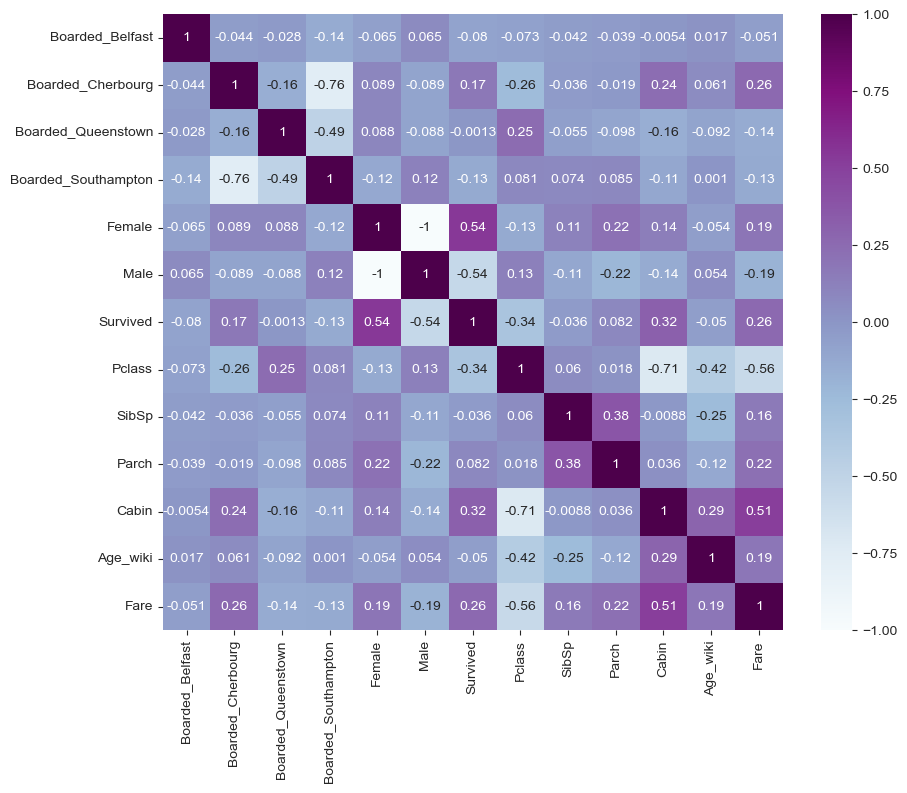

In [60]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='BuPu')

Looking at the Survived column it's easy to see that the highest positive correlation is 'Female', so merely being a Women would have the greatest survival rate, more than any other factor. The highest negatively correlated effect belonged to the 'Male' category. This had a much greater impact on survival rates than passenger class (Pclass) or even the fare paid so those who paid more for a first class ticket weren't necessarily secured a place on a lifeboat.

### Grouping Data Together
Taking a look at the average values for each feature based on their survival.

In [61]:
updated_df.groupby('Survived').mean()

,Boarded_Belfast,Boarded_Cherbourg,Boarded_Queenstown,Boarded_Southampton,Female,Male,Pclass,SibSp,Parch,Cabin,Age_wiki,Fare
Survived,,,,,,,,,,,,
0.0,0.016423,0.133212,0.085766,0.764599,0.147810,0.852190,2.534672,0.554745,0.330292,0.124088,29.866788,21.743056
1.0,0.000000,0.272727,0.085044,0.642229,0.680352,0.319648,1.947214,0.472141,0.466276,0.398827,28.434018,48.490116


### Combine SibSp and Parch
Creating a for loop to iterate through both columns and plotting them categorically.

<Figure size 640x480 with 0 Axes>

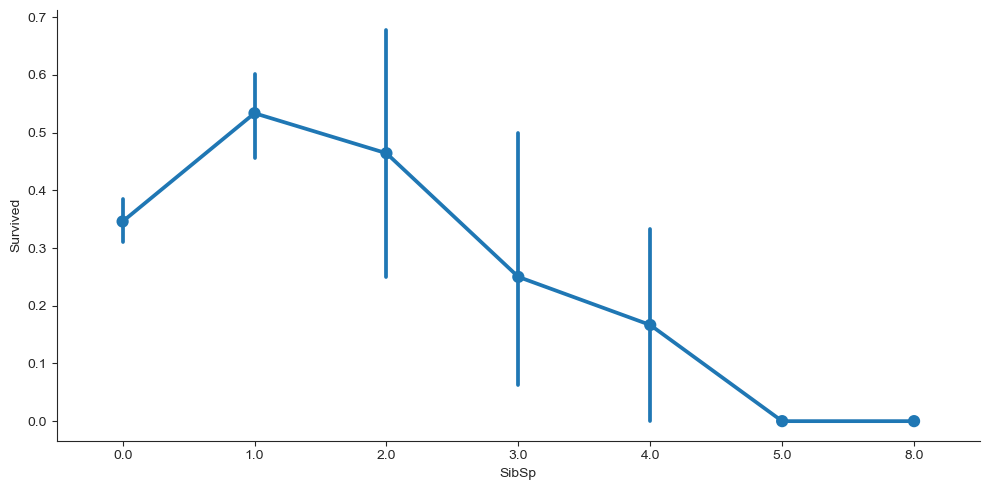

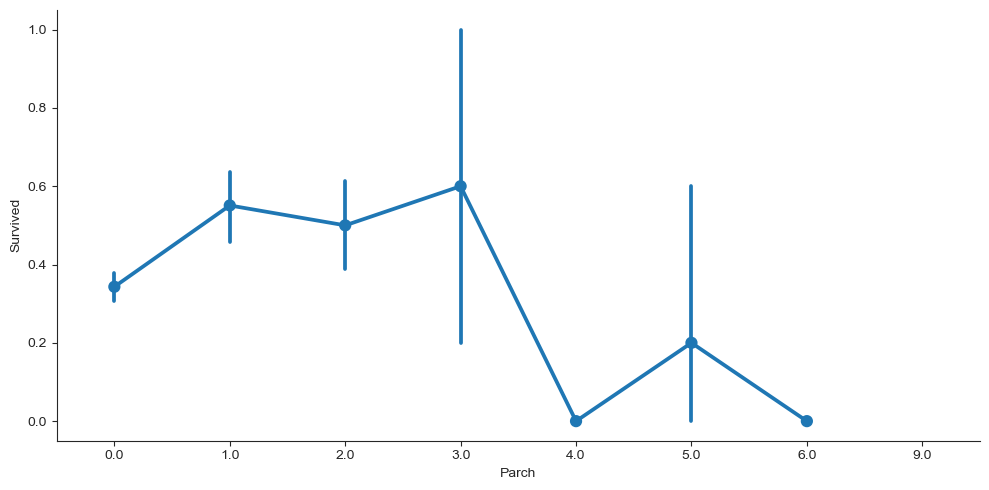

In [62]:
for i, col in enumerate(['SibSp', 'Parch']):
    plt.figure(i)
    sns.catplot(x=col, y='Survived', data=updated_df, kind='point', aspect=2, )

An extremely useful procedure when it comes to feature engineering involves combining columns, in this case 'SibSp' and 'Parch' into a new feature called 'Family_count'. It serves a similar purpose which is to provide counts or frequency of individuals traveling with their Parents or Brothers and Sisters, combining the values together and producing dimensionality reduction by reducing the number of columns and overal noise in the model.

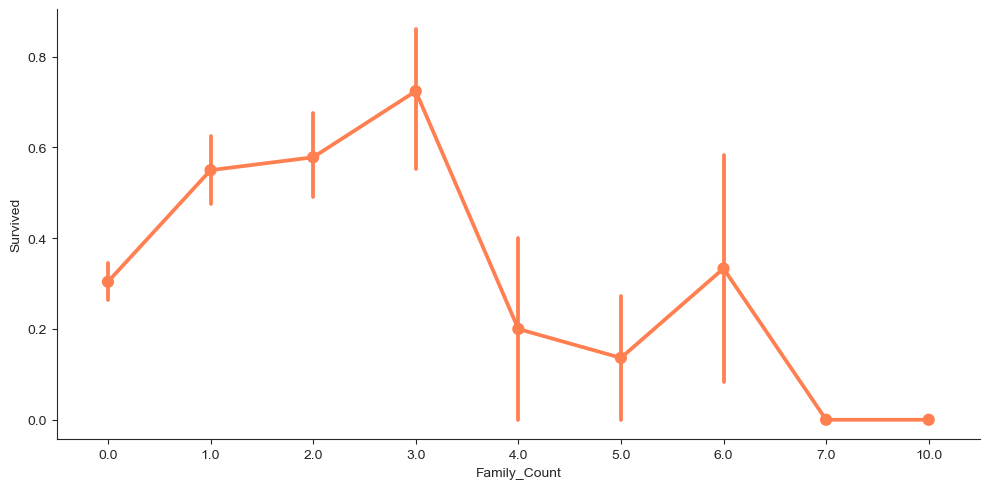

In [63]:
updated_df['Family_Count'] = updated_df['SibSp'] + updated_df['Parch']
sns.catplot(x='Family_Count', y='Survived', data=updated_df, kind='point', aspect=2, color="coral")

In [64]:
updated_df['Family_Count'] = updated_df['SibSp'] + updated_df['Parch']
updated_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
updated_df.head()

,Boarded_Belfast,Boarded_Cherbourg,Boarded_Queenstown,Boarded_Southampton,Female,Male,Survived,Pclass,Cabin,Age_wiki,Fare,Family_Count
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,22.0,7.2500,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,35.0,71.2833,1.0
2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,0.0,26.0,7.9250,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,35.0,53.1000,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,35.0,8.0500,0.0


A plot of Age and Survival Rate.

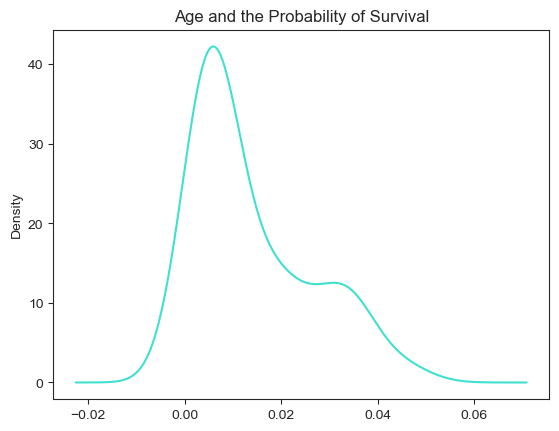

In [65]:
updated_df.Age_wiki.value_counts(normalize=True).plot(kind="kde", color="turquoise")
plt.title("Age and the Probability of Survival")
plt.show()

This shows a meaningful relationship across the Age spectrum. The older ages were less likely to survive and as the age diminishes, the likelihood goes up to between 20% and 60% for those less than the age of about 13.

The next step is to prepare the dataset with the correct number of total labeled entries. I can either change the data at source and slice it using Excel, or alternatively slice the data in Python to only include the first 891 passengers in the training data because these are the only results which are labeled. The reason this needs to be done is because of the risk of feeding inaccurate and unlabeled data back into the model (i.e. entries from 892 to 1304). Using un-labeled data will introduce bias into the classification results.

## Plot Continuous Features
These are separate from discrete values and deserve some attention.

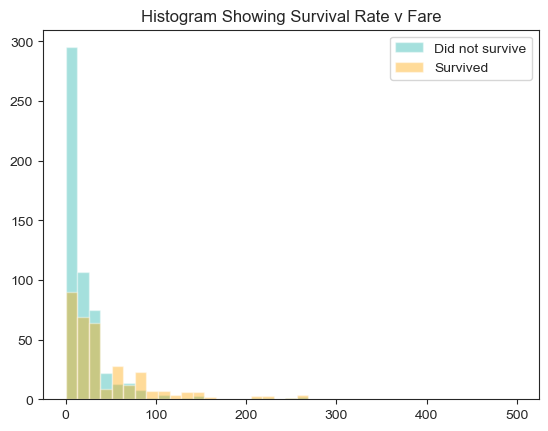

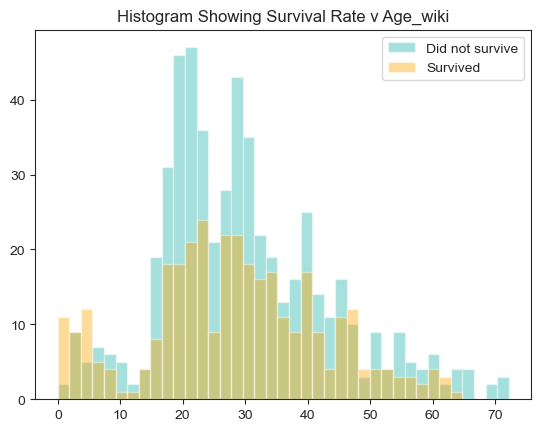

In [66]:
for i in ['Fare','Age_wiki']:
    died = list(updated_df[updated_df['Survived'] == 0][i].dropna())
    survived = list(updated_df[updated_df['Survived'] == 1][i].dropna())
    xmin = min(min(died), min(survived))
    xmax = max(max(died), max(survived))
    width = (xmax - xmin) / 40
    sns.distplot(died, color='lightseagreen', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(survived, color='orange', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Did not survive', 'Survived'])
    plt.title('Histogram Showing Survival Rate v {}'.format(i))
    plt.show()

This tells me that a far greater number of passengers in the 20-30 year age category did not survive relative to other age groups. Also, it appears that those who paid a lot more had better chances of survival.

What's the relationship between the continuous variables? A scatter plot can be used to describe this.

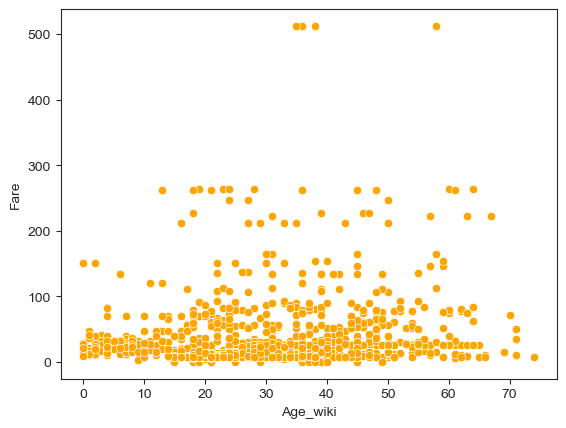

In [67]:
price = sns.scatterplot(data=updated_df, x=updated_df['Age_wiki'], y=updated_df['Fare'], color="orange")

This explains the range of fares paid by passengers according to age.

## Row Selection
This is where I determine the number of instances to train for model selection and at this stage it's best to employ the use of a Train, Test, Split algorithm using the labeled data (rows 1 to 889) which contains values for the target feature entitled 'Survived'. The model will fit to and learn from this data, then I can evaluate the efficiency of the chosen model against the unseen (un-labeled) data, rows 892 to 1304 which don't contain target values for the 'Survived' column. It's important to note that because I have already pre-processed the entire dataset from titanic.csv, I will have to split the data into subsets for 'labeled' and 'unlabeled' portions and apply the LogisticRegression() model to each separately.
### Nature of the Data
Change all features to integer values except for the 'Fare' column.

In [68]:
# change values to integers except for Fare and Survived columns
updated_df['Boarded_Belfast'] = updated_df['Boarded_Belfast'].astype('int')
updated_df['Boarded_Cherbourg'] = updated_df['Boarded_Cherbourg'].astype('int')
updated_df['Boarded_Queenstown'] = updated_df['Boarded_Queenstown'].astype('int')
updated_df['Boarded_Southampton'] = updated_df['Boarded_Southampton'].astype('int')
updated_df['Female'] = updated_df['Female'].astype('int')
updated_df['Male'] = updated_df['Male'].astype('int')
updated_df['Pclass'] = updated_df['Pclass'].astype('int')
updated_df['Cabin'] = updated_df['Cabin'].astype('int')
updated_df['Age_wiki'] = updated_df['Age_wiki'].astype('int')
updated_df['Family_Count'] = updated_df['Family_Count'].astype('int')

updated_df.head()

,Boarded_Belfast,Boarded_Cherbourg,Boarded_Queenstown,Boarded_Southampton,Female,Male,Survived,Pclass,Cabin,Age_wiki,Fare,Family_Count
0,0,0,0,1,0,1,0.0,3,0,22,7.2500,1
1,0,1,0,0,1,0,1.0,1,1,35,71.2833,1
2,0,0,0,1,1,0,1.0,3,0,26,7.9250,0
3,0,0,0,1,1,0,1.0,1,1,35,53.1000,1
4,0,0,0,1,0,1,0.0,3,0,35,8.0500,0


In [69]:
updated_df.columns

Index(['Boarded_Belfast', 'Boarded_Cherbourg', 'Boarded_Queenstown',
       'Boarded_Southampton', 'Female', 'Male', 'Survived', 'Pclass', 'Cabin',
       'Age_wiki', 'Fare', 'Family_Count'],
      dtype='object')

### Labeled Dataset Only
This set is reduced in size. It only contains instances where the target response was labeled which means only supervised learning algorithms can be applied before evaluating the result. An important point to remember here is that two 'Boarded' entries were removed between the index values of 0 and 891 (giving a total of 889 instances), so the new range of labeled entries will be between 0 and 889. The unlabeled entries span from index locations 889 to 1304.

The unlabeled portion of data residing between index locations 889 and 1304 would require a different type of machine learning model, or un-supervised algorithms such as visualization through clustering techniques, dimensionality reduction or associative rule modeling. See my k_means_clustering.ipynb model... 

In [70]:
# removing the 'Survived' column from the predictors DataFrame variable X
X = updated_df[:889].drop('Survived', axis=1).copy()
# assigning this dropped column to the target Series variable y
y = updated_df[:889]['Survived']

To clean up the dependent variable information, convert the y values to integers.

In [71]:
y = pd.Series(y).astype(int)

Checking the first few instances.

In [72]:
X.head()

,Boarded_Belfast,Boarded_Cherbourg,Boarded_Queenstown,Boarded_Southampton,Female,Male,Pclass,Cabin,Age_wiki,Fare,Family_Count
0,0,0,0,1,0,1,3,0,22,7.2500,1
1,0,1,0,0,1,0,1,1,35,71.2833,1
2,0,0,0,1,1,0,3,0,26,7.9250,0
3,0,0,0,1,1,0,1,1,35,53.1000,1
4,0,0,0,1,0,1,3,0,35,8.0500,0


In [73]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int32

This is correct! The first Null value should appear at index location 889, so there are a total of 888 labeled entries. Converting these dataframes to separate csv files so they can be viewed in Microsoft Excel if required.

In [74]:
X_to_csv = X.to_csv(r'C:/Users/lynst/Documents/GitHub/machine-learning-projects/supervised-learning/regression/logistic-regression/X.csv', index=False, header=True)
X

,Boarded_Belfast,Boarded_Cherbourg,Boarded_Queenstown,Boarded_Southampton,Female,Male,Pclass,Cabin,Age_wiki,Fare,Family_Count
0,0,0,0,1,0,1,3,0,22,7.2500,1
1,0,1,0,0,1,0,1,1,35,71.2833,1
2,0,0,0,1,1,0,3,0,26,7.9250,0
3,0,0,0,1,1,0,1,1,35,53.1000,1
4,0,0,0,1,0,1,3,0,35,8.0500,0
...,...,...,...,...,...,...,...,...,...,...,...
884,0,0,0,1,0,1,2,0,27,13.0000,0
885,0,0,0,1,1,0,1,1,19,30.0000,0
886,0,0,0,1,1,0,3,0,7,23.4500,3
887,0,1,0,0,0,1,1,1,26,30.0000,0


And the target labels.

In [75]:
y_to_csv = y.to_csv(r'C:/Users/lynst/Documents/GitHub/machine-learning-projects/supervised-learning/regression/logistic-regression/y.csv', index=False, header=True)
y

0      0
1      1
2      1
3      1
4      0
      ..
884    0
885    1
886    0
887    1
888    0
Name: Survived, Length: 889, dtype: int32

Looking at the new shape of the predictor dataframe:

In [76]:
X.shape

(889, 11)

This is better! Now I have the labeled instances for my independent variables, it's time to train and fit the data which means it needs to be split into training and validation sets before evaluating the model's accuracy.

### Split the Data

Having looked at the source data file, it hasn't been split into training or test data yet.

#### Single Holdout Set
Start with a single holdout validation, or test set to evaluate how well the model generalizes.

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

So 889 labels (y) are split into training (533 entries), validation (178 entries) and test sets (178 entries). 

In [78]:
print(len(y), len(y_train), len(y_val), len(y_test))

889 533 178 178


#### Scale the Different Ranges of Values
To improve accuracy before modeling by removing unecessary scale or unit measurement differences.

In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train the Data
Applying a Logistic Regression model to the labeled set and setting the 'multi_class' parameter equal to 'auto' because this will select a binary classifier automatically for the output array. Setting 'multi_class' equal to 'auto' is another way for the model to identify a binary problem to be fit to each label. If it had been a multi-class output then 'auto' would detect that also.

In [80]:
# import library then I can try different models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(multi_class='auto')
log_reg_clf = logistic_regression.fit(X_train,y_train)

Once the classification has been fit predictions can be made. The predict() method predicts the actual class below.

In [81]:
y_pred = log_reg_clf.predict(X_test)
y_pred

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1])

### Evaluation
Now I can evaluate the training set using the score method.

In [82]:
log_reg_clf.score(X_train, y_train)

0.7879924953095685

Performance on the validation set.

In [83]:
log_reg_clf.score(X_val, y_val)

0.6573033707865169

How does this score generalize to the test set?

In [84]:
log_reg_clf.score(X_test, y_test)

0.7865168539325843

Try removing the "Cabin" feature to see how much information is captured by the model this time.

In [89]:
X = updated_df[['Boarded_Belfast', 'Boarded_Cherbourg', 'Boarded_Queenstown', 'Boarded_Southampton', 'Female', 'Male', 'Pclass',
       'Age_wiki', 'Fare', 'Family_Count']].copy()
X = X[0:889]
X.head()

,Boarded_Belfast,Boarded_Cherbourg,Boarded_Queenstown,Boarded_Southampton,Female,Male,Pclass,Age_wiki,Fare,Family_Count
0,0,0,0,1,0,1,3,22,7.2500,1
1,0,1,0,0,1,0,1,35,71.2833,1
2,0,0,0,1,1,0,3,26,7.9250,0
3,0,0,0,1,1,0,1,35,53.1000,1
4,0,0,0,1,0,1,3,35,8.0500,0


Train the same model

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_regression = LogisticRegression(multi_class='auto')
log_reg_clf = logistic_regression.fit(X_train,y_train)

log_reg_clf.score(X_train, y_train)

0.799249530956848

Having dropped the Cabin feature there is a negligable improvement so the model captures a small incremental change in . Moving on to preprocessing, it may help to train a Polynomial function to fit the curve more accurately to the data.

### Cross-Validation
Fit and evaluate a basic model using 5-fold Cross-Validation known as K-Fold Cross Validation. The data will be divided into k subsets and the holdout set will be repeated k number of times until all the data points are used in the model.

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")

This is extremely useful as cross-validation will output score based on K number of folds, in this example 5 folds, which is directly controlled by the parameter cv=5. The highest accuracy score was based on the last 'test' subset of values 82.07%, however, when using K-Folds CV, the average score is taken.

In [ ]:
(0.80373832 + 0.77570093 + 0.77570093 + 0.71698113 + 0.82075472) / 5

So I can see that 77.86% is slightly worse than the previous score of 78.65%, but is probably a more accurate reflection of the score() method being applied to the test set (as the original score was based on the entire X and y dataset which is inaccurate due to training bias). 

### Leave 1-Out
This should only really be used for really small datasets when I could leave one value or observation out for validation after each training iteration but it would take too long for 889 instances.

### Confusion Matrix
Using a Confusion Matrix is a much better approach to measuring accuracy for a Classifier model such as Logistic Regression. This will display 'Actual' v 'Predicted' values. The left hand rows display 'Actual' negative and positive classes, and the colums display 'Predicted' negative and positive classes. It's important to make sure the length of the target series' are exactly the same for actual (y_test) and predicted (y_pred) values. 

It won't work by testing training data (y_train) because these account for 533 total instances, rather than 178 instances in the test set.

In [ ]:
# creating y_train_pred values:
y_train_pred = clf.predict(X_train)
y_train_pred[:5]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

conf = confusion_matrix(y_train, y_train_pred)
print(conf)

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

prec = precision_score(y_train, y_train_pred)
print(f"The Precision Accuracy Score is: ", prec)
rec = recall_score(y_train, y_train_pred)
print(f"The Recall Accuracy Score is: ", rec)
roc_auc = roc_auc_score(y_train, y_train_pred)
print(f"The Receiver Operation Characteristic-Area Under Curve Score is: ", roc_auc)

None of these scores are particularly great for prediction purposes! These are all predictions based on the training data, but shouldn't accuracy scores be applied to test data (target class y_test, and predicted class y_pred? What happens if I change the arguments for the confusion_matrix() function to contain the test set?

In [ ]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred)
conf

In [ ]:
# first row:
TN = 91
FP = 16
# second row:
FN = 22
TP = 49

Find the Precision score

In [ ]:
# accuracy of positive predictions
precision = TP / (TP + FP)
precision

Find the recall score

In [ ]:
# ratio of correctly predicted instances
recall = TP / (TP + FN)
recall

Plotting the Actual versus Predicted survival classes using the results from the Confusion Matrix above.

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# plotting actual v predicted values
plt.figure(figsize = (10,7))
plt.title("Actual v Predicted Survival Rates")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

Rather than using the confusion_matrix() function, importing separate precision and recall score functions may provide different accuracy results. Let's try!

In [ ]:
from sklearn.metrics import precision_score, recall_score

prec = precision_score(y_test, y_pred)
print(f"The Precision Accuracy Score is: ", prec)
rec = recall_score(y_test, y_pred)
print(f"The Recall Accuracy Score is: ", rec)

This indicates a slight improvement when predicting values in the test set, so it seems to generalize well to unseen data.

The predict_proba() method predicts the probability that each element falls within that particular class.

In [ ]:
log_reg_clf.predict_proba(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

### ROC Curve

In [ ]:
roc_auc = roc_auc_score(y_train, y_pred)
print(f"The Receiver Operation Characteristic-Area Under Curve Score is: ", roc_auc)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

y_scores = sgd_clf.decision_function(X_train)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

# plot the true-positive rate v false-positive rate
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    
plot_roc_curve(fpr, tpr)
plt.show()

The blue curve should be pushed as far to the top left-hand corner as possible for a more accurate model. This can be improved upon by applying a different model such as a Random Classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

rf = RandomForestClassifier(random_state=42)
y_prob_rf = cross_val_predict(rf, X_train, y_train, cv=3, method="predict_proba")

y_scores_rf = y_prob_rf[:, :1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_rf)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(tpr_rf, fpr_rf, "Random Forest Model")
plt.legend(loc="lower right")
plt.show()

So the Random Forest Classifier model has improved the Area Under the Curve because it is better at predicting the target values, or survival rate in this model.

### Unlabeled Dataset
Repeating this train-test-split but using the unlabeled values in the dataset, from index location 892 to 1304.

In [ ]:
# removing the 'Survived' column from the predictors DataFrame variable X
X_train = updated_df.drop("Survived", axis=1)
X_train = updated_df.iloc[0:889]
# assigning this dropped column to the target Series variable y
y_train = updated_df["Survived"]
y_train = y_train.iloc[0:889]
# assigning the test set
test_df = updated_df.drop("Survived", axis=1).copy()
X_test = test_df.iloc[890:1304]

X_train isn't dropping 'Survived' for some reason!!!

In [ ]:
# find the shape of each set
X_train.shape, y_train.shape, X_test.shape

In [ ]:
X_train.tail()

In [ ]:
y_train.tail()

In [ ]:
X_test.tail()

Check the respective length of the different sets.

In [ ]:
#remove rows with any values that are not finite
X_test = X_test[np.isfinite(test_df).all(1)]

#view updated DataFrame
X_test

Train and fit the model again.

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_new = LogisticRegression()
log_reg_new.fit(X_train, y_train)
y_pred = log_reg_new.predict(X_test)
acc_log = round(log_reg_new.score(X_train, y_train) * 100, 2)
acc_log

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(multi_class='ovr')
log_reg_clf.fit(X_train,y_train)

In [ ]:
y_pred = log_reg_clf.predict(X_test)
y_pred

In [ ]:
log_reg_clf.score(X, y)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(log_reg_clf, X_train, y_train, cv=5, scoring="accuracy")

In [ ]:
# creating y_train_pred values:
y_train_pred = log_reg_clf.predict(X_train)
y_train_pred[:5]

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# plotting actual v predicted values
plt.figure(figsize = (10,7))
plt.title("Actual v Predicted Survival Rates")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [ ]:
# first row:
TN = 
FP = 
# second row:
FN = 
TP = 

In [ ]:
prec = precision_score(y_test, y_pred)
print(f"The Precision Accuracy Score is: ", prec)
rec = recall_score(y_test, y_pred)
print(f"The Recall Accuracy Score is: ", rec)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"The Receiver Operation Characteristic-Area Under Curve Score is: ", roc_auc)

In [ ]:
log_reg_clf.predict_proba(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

y_scores = sgd_clf.decision_function(X_train)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

# plot the true-positive rate v false-positive rate
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
X_train.to_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/train_features.csv', index=False)
X_val.to_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/val_features.csv', index=False)
X_test.to_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/test_features.csv', index=False)

y_train.to_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/train_labels.csv', index=False)
y_val.to_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/val_labels.csv', index=False)
y_test.to_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/test_labels.csv', index=False)

In [ ]:
# Write out cleaned data
titanic.to_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/titanic_cleaned.csv', index=False)

## Improving Evaluation Metrics
Iterating the process with new algorithms and improving the evaluation scores. I will repeat this process by trying out iterations changing Parameters and Hyperparameters.

In [ ]:
import pandas as pd
from sklearn.ensemble import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
tree_clf = dtc.fit()
tree_clf = tree_clf.transform()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

tr_features = pd.read_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/train_features.csv')
tr_labels = pd.read_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/train_labels.csv', header=None)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
rf = RandomForestClassifier()

scores = cross_val_score(rf, tr_features, tr_labels.values.ravel(), cv=5)
scores

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

## Pipeline: Evaluate results on validation set
Using the Titanic dataset from this Kaggle competition.

In this section, we will use what we learned in last section to fit the best few models on the full training set and then evaluate the model on the validation set.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

tr_features = pd.read_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/train_features.csv')
tr_labels = pd.read_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/train_labels.csv', header=None)

val_features = pd.read_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/val_features.csv')
val_labels = pd.read_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/val_labels.csv', header=None)

te_features = pd.read_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/test_features.csv')
te_labels = pd.read_csv('C:/Users/lynst/Documents/Python Scripts/Ex_Files_Applied_Machine_Learning/Exercise Files/test_labels.csv', header=None)

In [ ]:
rf1 = RandomForestClassifier(n_estimators=5, max_depth=10)
rf1.fit(tr_features, tr_labels.values.ravel())

rf2 = RandomForestClassifier(n_estimators=100, max_depth=10)
rf2.fit(tr_features, tr_labels.values.ravel())

rf3 = RandomForestClassifier(n_estimators=100, max_depth=None)
rf3.fit(tr_features, tr_labels.values.ravel())

In [ ]:
for mdl in [rf1, rf2, rf3]:
    y_pred = mdl.predict(val_features)
    accuracy = round(accuracy_score(val_labels, y_pred), 3)
    precision = round(precision_score(val_labels, y_pred), 3)
    recall = round(recall_score(val_labels, y_pred), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

In [ ]:
y_pred = rf2.predict(te_features)
accuracy = round(accuracy_score(te_labels, y_pred), 3)
precision = round(precision_score(te_labels, y_pred), 3)
recall = round(recall_score(te_labels, y_pred), 3)
print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(rf2.max_depth,
                                                                     rf2.n_estimators,
                                                                     accuracy,
                                                                     precision,
                                                                     recall))

In [ ]:
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p wget,pandas,numpy,watermark,matplotlib,seaborn,sklearn,warnings

# date
print (" ")
%watermark -u -n -t -z